# 報酬関数によるConvex MDPの実現

参考：
* [Reward is Enough for Convex MDPs](https://arxiv.org/abs/2106.00661)
* [Imitation Learning as f-Divergence Minimization](https://arxiv.org/abs/1905.12888)：参考になるかも．特にGAIL系の場合

強化学習では通常，次の問題を解きます：

$$
\mathrm{RL}: \quad \max _{d_\pi \in \mathcal{K}} \sum_{s, a} r(s, a) d_\pi(s, a)
$$

これは$d_\pi$について凸な最適化問題ですね．一方で，次のような一般的な凸最適化問題を考えることができます．

$$
\text { Convex MDP: } \quad \min _{d_\pi \in \mathcal{K}} f\left(d_\pi\right) \text {, }
$$

ここで$f: \mathcal{K}\to \mathbb{R}$は凸関数です．
この$f$を変えることで様々な別の問題を導出することができます．
例えば$f(d_\pi)=d_\pi \cdot \log(d_\pi)$とすると，これはreward free MDPと同じです．

このような一般のConvex MDPは実は報酬と方策側のMin-maxゲームとして解くことができます．

表記：Average-rewardを考えることもできますが，面倒なので割引ありのケースだけ考えます．
* $J_\pi^\gamma=(1-\gamma) \mathbb{E} \sum_{t=1}^{\infty} \gamma^t r_t$
* $d_\pi^\gamma(s, a)=(1-\gamma) \mathbb{E} \sum_{t=1}^{\infty} \gamma^t \mathbb{P}_\pi\left(s_t=s\right) \pi(s, a)$

とします．すると，
* $J_\pi=\sum_{s, a} r(s, a) d_\pi(s, a)$
* $\mathcal{K}_\gamma=\left\{d_\pi \mid d_\pi \geq 0, \quad \sum_a d_\pi(s, a)=(1-\gamma) d_0(s)+\gamma \sum_{s^{\prime}, a^{\prime}} P\left(s, s^{\prime}, a^{\prime}\right) d_\pi\left(s^{\prime}, a^{\prime}\right) \quad \forall s \in S\right\}$

が成立します．
Convex MDPは$\left(S, A, P, f, \gamma, d_0\right)$として定義されます．

## Convex MDPをRLで解く

凸共役を利用することでconvex MDPはRLを利用して解くことができます．
次のFenchel conjugateを思い出しましょう．

---

**Fenchel conjugate**

$f: \mathbb{R}^n \rightarrow \mathbb{R} \cup\{-\infty, \infty\}$に対して，次の$f^*: \mathbb{R}^n \to \mathbb{R}\cup \{-\infty, \infty\}$
$$
f^*(x):=\sup _y x \cdot y-f(y)
$$
のことを$f$のFenchel conjugateと呼ぶ．

$f^*$は常に凸関数であり，また，$f=f^{**}$であることに注意しましょう．

---

これを使うと，

$$
f^{\mathrm{OPT}}=\min _{d_\pi \in \mathcal{K}} f\left(d_\pi\right)=\min _{d_\pi \in \mathcal{K}} \max _{\lambda \in \Lambda}\left(\lambda \cdot d_\pi-f^*(\lambda)\right)=\max _{\lambda \in \Lambda} \min _{d_\pi \in \mathcal{K}}\left(\lambda \cdot d_\pi-f^*(\lambda)\right)
$$

として表すことができます．
ここで$\Lambda$は$\left\{\partial f\left(d_\pi\right) \mid d_\pi \in \mathcal{K}\right\}$の閉包であり，凸集合です．

---

**$\Lambda$についての補足**

$f$が微分可能である場合，$\sup _y x \cdot y-f(y)$を与えるどの$y^*$も$x=\nabla f(y^*)$を満たすことを思い出しましょう．（[CVX_convex_functions.ipynb](CVX_convex_functions.ipynb)参照）

また，その閉包が凸集合であることの証明は[On Frank-Wolfe and Equilibrium Computation](https://papers.nips.cc/paper_files/paper/2017/hash/7371364b3d72ac9a3ed8638e6f0be2c9-Abstract.html)のTheorem 4を参照してください．

---

また，最後にmin-maxがひっくり返せるのは$\lambda$と$d_\pi$について凸であるためですね．
さて，次のラグランジアンを定義しましょう．
$$
\mathcal{L}\left(d_\pi, \lambda\right):=\lambda \cdot d_\pi-f^*(\lambda)
$$
固定された$\lambda$に対して，$\mathcal{L}$の最小化は通常のRLで実現されます．よって，もし最適な$\lambda^*$があれば最適な$d_\pi^*$が手に入るような気がしますが，次のように，それができない場合があります．


---

$$
\arg \max _{d_\pi \in \mathcal{K}} d_\pi \cdot r=\arg \min _{d_\pi \in \mathcal{K}} f\left(d_\pi\right)
$$

が成立するような報酬が存在しないようなMDPと凸関数$f$が存在する．

**証明**

CMDPで決定的な方策が最適にならない状況などを考えればすぐにわかりそうです．

---

単純に$\arg\max$を取ると最適解が得られない可能性がありますが，次のようにして全ての更新の平均を取ると，最終的に最適解に収束します．

$$
\begin{aligned}
& \text { for } k=1, \ldots, K \text { do } \\
& \quad \lambda^k=\operatorname{Alg}_\lambda\left(d_\pi^1, \ldots, d_\pi^{k-1} ; \mathcal{L}\right) \\
& \quad d_\pi^k=\operatorname{Alg}_\pi\left(-\lambda^k\right) \\
& \text { end for } \\
& \text { Return } \bar{d}_\pi^K=\frac{1}{K} \sum_{k=1}^K d_\pi^k, \bar{\lambda}^K=\frac{1}{K} \sum_{k=1}^K \lambda^k
\end{aligned}
$$

具体的な$\operatorname{Alg}$の設計は後で見ます．

---

**補足**

[ReLOAD: Reinforcement Learning with Optimistic Ascent-Descent for Last-Iterate Convergence in Constrained MDPs](https://arxiv.org/abs/2302.01275)を使うと，平均を取らずに最終的な最適解への収束を実現できます．

---

この$\operatorname{Alg}$はどのような性質を満たすべきでしょうか？
そのために，一連の流れをオンライン凸最適化として捉えます．

オンライン凸最適化では$K$個の凸な損失関数$\ell_1, \ell_2, \ldots, \ell_K: \mathcal{K} \rightarrow \mathbb{R}$を各ステップで最適化することを考えます．
最適化では，次の平均リグレットを最小化することを目的にします．
$$
\bar{R}_K:=\frac{1}{K}\left(\sum_{k=1}^K \ell_k\left(x_k\right)-\min _{x \in \mathcal{K}} \sum_{k=1}^K \ell_k(x)\right)
$$

上のアルゴリズムにおいては，コスト側のプレイヤ＝は$\ell_\lambda^k=-\mathcal{L}\left(\cdot, \lambda^k\right)$を，方策側のプレイヤーは$\ell_\pi^{\bar{k}}=\mathcal{L}\left(d_\pi^k, \cdot\right)$を扱います．それぞれのリグレットを$\bar{R}^\pi_K$，$\bar{R}^\lambda_K$としましょう．このとき，次が成立します．

---

$\bar{R}^\pi_K \leq \epsilon_K$と$\bar{R}^\lambda_K\leq \delta_K$が成立するとき，
$\bar{d}^K_\pi$と$\bar{\lambda}^K$は

$$
\min _{d_\pi \in \mathcal{K}} \mathcal{L}\left(d_\pi, \bar{\lambda}^K\right) \geq f^{O P T}-\epsilon_K-\delta_K \text { and } \max _{\lambda \in \Lambda} \mathcal{L}\left(\bar{d}_\pi^K, \lambda\right) \leq f^{O P T}+\epsilon_K+\delta_K
$$

を満たす．
また，

$$f^{\mathrm{OPT}} \leq f\left(\bar{d}_\pi^K\right)=\max _\lambda \mathcal{L}\left(\bar{d}_\pi^K, \lambda\right) \leq f^{\mathrm{OPT}}+\epsilon_K+\delta_K$$

なので，リグレットが小さいアルゴリズムを使うことでnear-optimalな$d_\pi$が得られます．

---


## いろいろなアルゴリズム

### コスト側のプレイヤー

基本的には勾配降下法などで$\mathcal{L}$を$\lambda$について下げます．

---

**Follow the Leader (FTL)**

Follow the leaderアルゴリズムは次のようにして$\lambda$を更新します（今までのコストの和を一番小さくする$\lambda$を選択するわけですね）．

$$
\lambda^k=\arg \max _{\lambda \in \Lambda} \sum_{j=1}^{k-1} \mathcal{L}\left(d_\pi^j, \lambda\right)=\arg \max _{\lambda \in \Lambda}\left(\lambda \cdot \sum_{j=1}^{k-1} d_\pi^j-K f^*(\lambda)\right)
$$

ここで，[凸共役性のwiki](https://ja.wikipedia.org/wiki/%E5%87%B8%E5%85%B1%E5%BD%B9%E6%80%A7)などを参考にすれば，

$$
\begin{aligned}
\nabla f(x) &= \arg\max_{\lambda \in \Lambda} \lambda \cdot x - f^*(\lambda)\\
\nabla f^*(\lambda) &= \arg\max_{x \in \mathcal{X}} \lambda \cdot x - f(x)\\
\end{aligned}
$$

が成り立つので，$\bar{d}_\pi^{k-1}=\sum_{j=1}^{k-1} d_\pi^j$とすれば，

$$
\lambda^k=\nabla f\left(\bar{d}_\pi^{k-1}\right)
$$

とできます．このとき，FTLのリグレットは$\bar{R}_K \leq c / \sqrt{K}$であることが保証されます．

---

**Online Mirror Descent (OMD)**

OMDアルゴリズムは次のようにして$\lambda$を更新します．

$$
\lambda^k=\arg \max _{\lambda \in \Lambda}\left(\left(\lambda-\lambda^{k-1}\right) \cdot \nabla_\lambda \mathcal{L}\left(d_\pi^{k-1}, \lambda^{k-1}\right)+\alpha_k B_r\left(\lambda, \lambda^{k-1}\right)\right)
$$

ここで，$B_r$はBregmanダイバージェンスです．特に$B_r(x)=0.5\|x\|_2^2$のときはOnline gradient descentになります（つまり，単純に$d^{k-1}_\pi$を固定した$\mathcal{L}$に対して勾配降下をするだけですね．）．
OMDアルゴリズムのリグレットは$\bar{R}_K \leq c / \sqrt{K}$であることが保証されます．

---

### 方策側のプレイヤー

---

**Best Response**

一番単純なのは，$\lambda$が与えられたときのRLを解くことです．

$$
d_\pi^k=\arg \min _{d_\pi \in \mathcal{K}} \mathcal{L}_k\left(d_\pi, \lambda^k\right)=\arg \min _{d_\pi \in \mathcal{K}} d_\pi \cdot \lambda^k-f^*\left(\lambda^k\right)=\arg \max _{d_\pi \in \mathcal{K}} d_\pi \cdot\left(-\lambda^k\right),
$$

このときのリグレットは０になります．
また，ExactにMaxを解くのではなく，近似解を求めるのも良いです．（論文参照）

---

**Non-stationary RL**

毎回$\varepsilon$-最適な方策を求めるのは大変なので，１ステップで１回だけRLを更新することも考えられます．
論文ではUCRL2を使った状況について議論してるので，よく読んでみましょう．


## 制約がついた場合

次のように，制約がついたConvex MDPを考えることができます．

$$
\min _{d_\pi \in \mathcal{K}} f\left(d_\pi\right) \quad \text { subject to } \quad g_i\left(d_\pi\right) \leq 0, \quad i=1, \ldots m
$$

ここで，$f$と$g_i$は凸関数です．このラグランジュ形式を考えてみましょう．$\mu \in \mathbb{R}_+$と$v$（$d$と同じ次元です）を使って，

$$
L\left(d_\pi, \mu\right)=f\left(d_\pi\right)+\sum_{i=1}^m \mu_i g_i\left(d_\pi\right)=\max _\nu\left(\nu \cdot d_\pi-f^*(\nu)\right)+\sum_{i=1}^m \mu_i \max _{v_i}\left(d_\pi v_i-g_i^*\left(v_i\right)\right) .
$$

であり，これはConvex-concaveの形式に見えませんが，$\zeta_i=\mu_i v_i$を導入すれば，

$$
L\left(d_\pi, \mu, \nu, \zeta_1, \ldots, \zeta_m\right)=\nu \cdot d_\pi-f^*(\nu)+\sum_{i=1}^m\left(d_\pi \zeta_i-\mu_i g_i^*\left(\zeta_i / \mu_i\right)\right)
$$

となり，これは$d_\pi$について凸かつ$\left(\nu, \mu, \zeta_1, \ldots, \zeta_m\right)$について凹です．



# いろいろな問題

これまでの内容を踏まえると，
* 凸関数$f$
* コスト側のプレイヤー
* 方策側のプレイヤー

のアルゴリズムを色々変えることで，様々な問題を復元できます．下の図参照．

![convex-mdp](figs/convex_MDP.png)

In [83]:
import numpy as np
from itertools import product
from functools import partial
from typing import Optional, NamedTuple
import jax.numpy as jnp

S = 40
A = 8
S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.98
horizon = int(1 / (1 - gamma))


def create_cost_rew_P(S: int, A: int, head_prob: float):
    """ Gambler's Problem (報酬関数, 遷移確率) を作成します

    Args:
        S (int): 状態空間のサイズ
        A (int): 行動空間のサイズ
        head_prob (float): コインの表が出る確率

    Returns:
        cost (float): コスト関数
        rew (float): 報酬関数
        P (float): 遷移確率
    """


    # 一番右側の状態で1がもらえます
    # s=1を一番左側の状態として、s=0は吸収状態とします
    rew = np.zeros((S, A))
    rew[-1] = 1
    
    # 3の倍数のマスを踏むとコストが発生します
    cost = np.zeros((S, A))
    for s in range(S):
        if s % 3 == 1:
            cost[s, :] = 1.0

    # コインの表が出ると右に、裏が出ると左に動きます。動く距離は行動の数に従います。
    P = np.zeros((S, A, S))
    for s, a in product(range(S), range(A)):
        if s == 0:  # 吸収状態
            P[s, a, 0] = 1
            continue
            
        next_s_down = max(1, s-a)  # 裏が出る
        next_s_up = min(s+a, S-1)  # 表が出る
        if next_s_down == next_s_up:
            P[s, a, next_s_down] = 1
        else:
            P[s, a, next_s_down] = 1 - head_prob
            P[s, a, next_s_up] = head_prob
    np.testing.assert_almost_equal(P.sum(axis=-1), 1)
    return np.array(cost), np.array(rew), np.array(P)


# 初期分布を作ります
mu = np.zeros(S)
mu[int(S / 2)] = 1.0  # 真ん中からスタート
np.testing.assert_almost_equal(mu.sum(axis=-1), 1)  # ちゃんと確率行列になっているか確認します


class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # エフェクティブホライゾン
    rew: np.array  # 報酬行列
    cost: np.ndarray  # コスト行列
    thresh: float  # 閾値
    P: np.array  # 遷移確率行列
    mu: np.array  # 初期分布

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)


# 基本のPを作ります
cost, rew, P = create_cost_rew_P(S, A, 0.6)
thresh = 1.0
mdp = MDP(S_array, A_array, gamma, horizon, rew, cost, thresh, P, mu)

In [84]:
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
import chex


@jax.jit
def compute_greedy_policy(Q: jnp.ndarray):
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy


@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, rew: jnp.ndarray, S: int, A: int):
    def backup(optimal_Q):
        next_v = mdp.P @ optimal_Q.max(axis=1)
        assert next_v.shape == (S, A)
        return rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon * 5, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp, rew: _compute_optimal_Q(mdp, rew, mdp.S, mdp.A)


@jax.jit
def compute_policy_Q(mdp: MDP, rew: jnp.ndarray, policy: jnp.ndarray):
    S, A = policy.shape
    chex.assert_shape(policy, (mdp.S, mdp.A))

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon * 5, body_fn, policy_Q)


@jax.jit
def compute_policy_matrix(policy: jnp.ndarray):
    """
    上で定義した方策行列を計算します。方策についての内積が取りたいときに便利です。
    Args:
        policy (jnp.ndarray): (SxA)の行列

    Returns:
        policy_matrix (jnp.ndarray): (SxSA)の行列
    """
    S, A = policy.shape
    PI = policy.reshape(1, S, A)
    PI = jnp.tile(PI, (S, 1, 1))
    eyes = jnp.eye(S).reshape(S, S, 1)
    PI = (eyes * PI).reshape(S, S*A)
    return PI


@jax.jit
def compute_policy_visit_sa(mdp: MDP, policy: jnp.ndarray):
    S, A = policy.shape
    chex.assert_shape(policy, (mdp.S, mdp.A))
    Pi = compute_policy_matrix(policy)
    PPi = mdp.P.reshape(S*A, S) @ Pi 

    def backup(visit):
        next_visit = mdp.gamma * visit @ PPi
        return (1 - mdp.gamma) * mdp.mu @ Pi + next_visit
    
    body_fn = lambda i, visit: backup(visit)
    visit = jnp.zeros(S*A)
    visit = jax.lax.fori_loop(0, mdp.horizon * 5, body_fn, visit)
    visit = visit.reshape(S, A)
    return visit


## 単純なRL

* 凸関数$f$：$f(d_\pi) = -r^\top d_\pi$
    * $\nabla f(d) = -r^\top$なので，$\Lambda=\{r^\top\}$です
* コスト側：Follow the Leader
* 方策側：RL

の場合を考えましょう．この凸共役について，
$$
f^*(x) = \sup_d x^\top d + r^\top d
$$
ですが，$x=-r$だけなので，これは常に０です．ちなみにアルゴリズムに当てはめれば，

$$
\begin{aligned}
\lambda^k &= \nabla f(\bar{d}_\pi^{k-1}) = -r^\top\\
d^k_\pi &= \arg \max_{d_\pi \in \mathcal{K}} d_\pi \cdot (-\lambda^k)
= \arg \max_{d_\pi \in \mathcal{K}} d_\pi \cdot r
\end{aligned}
$$


Text(0.5, 0, 'Iteration')

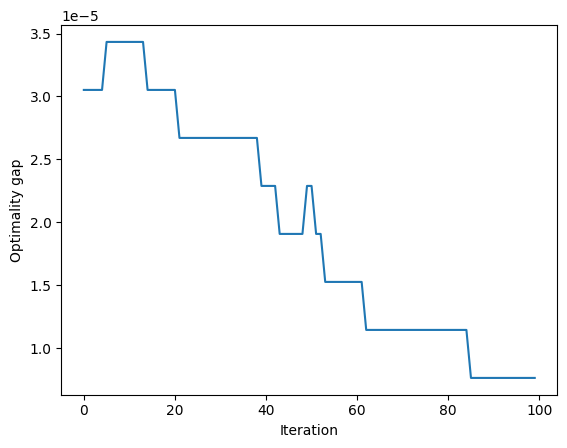

In [77]:
# 普通のRLを解きます．
import matplotlib.pyplot as plt

K = 100

lam_avg = 0
d_avg = 0

gaps = []

for k in range(K):
    lam = -mdp.rew
    opt_Q = compute_optimal_Q(mdp, -lam)
    policy = compute_greedy_policy(opt_Q)
    d = compute_policy_visit_sa(mdp, policy)
    d_avg += d
    d = d_avg / (k + 1)
    ret = d.reshape(-1) @ mdp.rew.reshape(-1) / (1 - mdp.gamma)
    gaps.append(mdp.mu @ compute_optimal_Q(mdp, mdp.rew).max(axis=-1) - ret)


plt.plot(gaps)
plt.ylabel("Optimality gap")
plt.xlabel("Iteration")



## Apprenticeship learning

* 凸関数$f$：$f(d_\pi) = \|d_\pi - d_E \|_2^2 = \sum_{s, a} (d_\pi(s, a) - d_E(s, a))^2$
    * $\nabla f(d) = 2(d - d_E)$
* コスト側：Follow the Leader
* 方策側：Best response

の場合，

$$
\begin{aligned}
\lambda^k &= \nabla f(\bar{d}_\pi^{k-1}) = 2(\bar{d}_\pi^{k-1} - d_E)\\
d^k_\pi &= \arg \max_{d_\pi \in \mathcal{K}} d_\pi \cdot (-\lambda^k)
\end{aligned}
$$




Text(0.5, 0, 'Iteration')

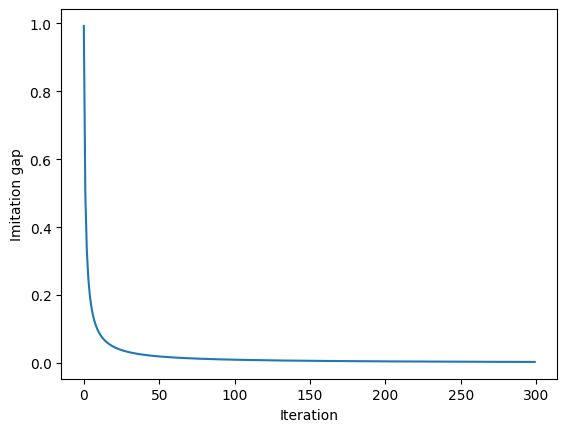

In [67]:
# ALを解きます．適当な方策の模倣学習です．

# 適当な方策を作ります．
key = jax.random.PRNGKey(0)
expert = jax.random.uniform(key, (S, A))
expert = expert / expert.sum(axis=-1, keepdims=True)
expert_visit = compute_policy_visit_sa(mdp, expert)

K = 300

lam_avg = 0
d_avg = 0
lam = jnp.zeros((S, A))
gaps = []

for k in range(K):
    opt_Q = compute_optimal_Q(mdp, -lam)
    policy = compute_greedy_policy(opt_Q)
    d = compute_policy_visit_sa(mdp, policy)
    d_avg += d

    lam = 2 * (d_avg / (k+1) - expert_visit)
    lam_avg += lam

    d = d_avg / (k + 1)
    gaps.append(jnp.abs(d - expert_visit).max())


plt.plot(gaps)
plt.ylabel("Imitation gap")
plt.xlabel("Iteration")


## Reward Free

* 凸関数$f$：$f(d_\pi) = d_\pi \cdot \log(d_\pi)$
    * $\nabla f(d) = I + \log(d)$
* コスト側：Follow the Leader
* 方策側：Best response

の場合，

$$
\begin{aligned}
\lambda^k &= \nabla f(\bar{d}_\pi^{k-1}) = I + \log(\bar{d}_\pi^{k-1})\\
d^k_\pi &= \arg \max_{d_\pi \in \mathcal{K}} d_\pi \cdot (-\lambda^k)
\end{aligned}
$$




Text(0.5, 0, 'Iteration')

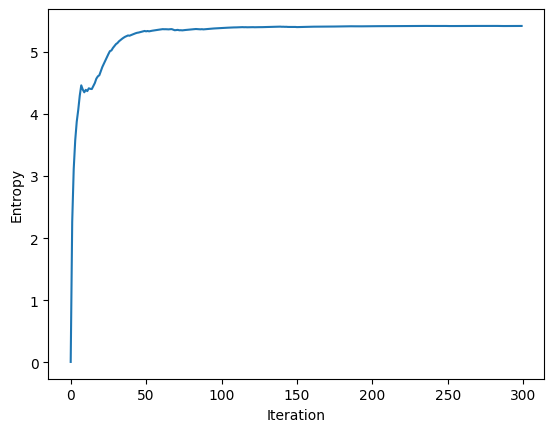

In [68]:
# ALを解きます．適当な方策の模倣学習です．

K = 300

lam_avg = 0
d_avg = 0
lam = jnp.ones((S, A))
entropys = []

for k in range(K):
    opt_Q = compute_optimal_Q(mdp, -lam)
    policy = compute_greedy_policy(opt_Q)
    d = compute_policy_visit_sa(mdp, policy)
    d_avg += d

    lam = jnp.ones((S, A)) + jnp.log(d_avg / (k+1) + 1e-8)
    lam_avg += lam

    d = d_avg / (k + 1)
    entropys.append(-(d * jnp.log(d + 1e-8)).sum())


plt.plot(entropys)
plt.ylabel("Entropy")
plt.xlabel("Iteration")

## Constrained MDP


$$
\min _{d_\pi \in \mathcal{K}} f\left(d_\pi\right) \quad \text { subject to } \quad g_i\left(d_\pi\right) \leq 0, \quad i=1, \ldots m
$$

に対して，$m=1$として，

* 凸関数$f$：$f(d_\pi) = -r \cdot d_\pi$
* 凸制約：$g(d_\pi) = c\cdot d_\pi - b$
* コスト側：Online Mirror Descent
* 方策側：RL

の場合を考えましょう．$f$の凸共役について，
$$
f^*(x) = \sup_d x^\top d + r^\top d
$$
ですが，$x=-r$だけなので，これは常に０です．一方で$g$の凸共役は
$$
g^*(x) = \sup_d x^\top d - c^\top d + b
$$
であり，$x=c$だけなので，これは常に$b$です．よってグランジュ形式は

$$
\begin{aligned}
L\left(d_\pi, \lambda, \nu, \zeta_1, \ldots, \zeta_m\right)&=\nu \cdot d_\pi-f^*(\nu)+\sum_{i=1}^m\left(d_\pi \zeta_i-\lambda_i g_i^*\left(\zeta_i / \lambda_i\right)\right)\\
&= -r \cdot d_\pi + (\lambda c \cdot d_\pi  - \lambda b)\\
&= -r \cdot d_\pi + \lambda(c \cdot d_\pi  - (1 - \gamma)b\cdot d_\pi)\\
&= \left(-r+\lambda \left(c - (1 - \gamma)\right)b\right) \cdot d_\pi
\end{aligned}
$$

になります．これを$d_\pi$について最小化，$\lambda$について最大化すれば良いわけですね．
$\lambda$についてOMDを使い，$d_\pi$は普通にRLすると，

$$
\begin{aligned}
\lambda^k &= \lambda^{k-1} - \alpha (b - c\cdot d_\pi^{k-1})\\
d^k_\pi &= \arg \max_{d_\pi \in \mathcal{K}} d_\pi \cdot (r + \lambda^k((1 - \gamma)b - c))
\end{aligned}
$$

になります．

Text(0.5, 0, 'Iteration')

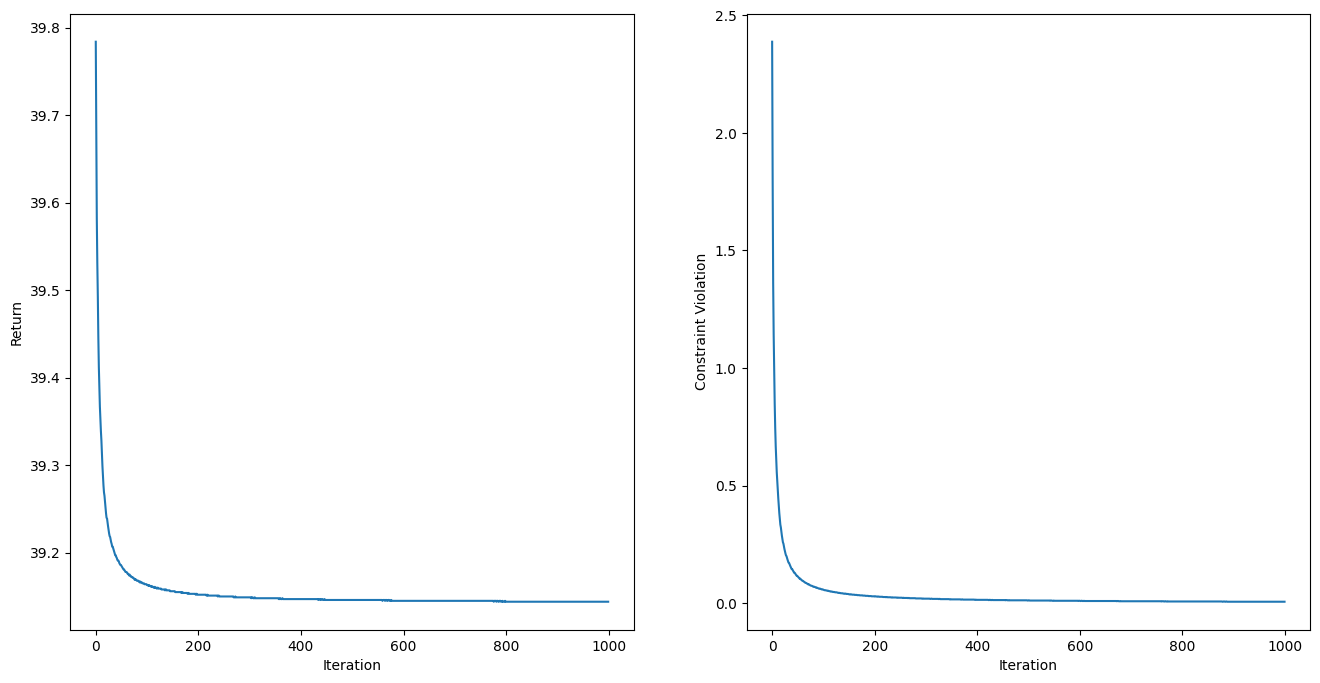

In [93]:
# ALを解きます．適当な方策の模倣学習です．

K = 1000

lam_avg = 0
d_avg = 0
lr = 0.1
lam = jnp.zeros((S, A))
rets = []
vios = []

for k in range(K):
    lam_rew = mdp.rew + lam * ((1 - mdp.gamma) * mdp.thresh - mdp.cost)
    opt_Q = compute_optimal_Q(mdp, lam_rew)
    policy = compute_greedy_policy(opt_Q)
    d = compute_policy_visit_sa(mdp, policy)
    d_avg += d

    lam = jnp.maximum(lam - lr * (mdp.thresh - mdp.cost.reshape(-1) @ d.reshape(-1) / (1 - mdp.gamma)), 0)
    lam_avg += lam

    d = d_avg / (k + 1)
    ret = d.reshape(-1) @ mdp.rew.reshape(-1) / (1 - mdp.gamma)
    vio = jnp.maximum(d.reshape(-1) @ mdp.cost.reshape(-1) / (1 - mdp.gamma) - mdp.thresh, 0)

    rets.append(round(ret, 3))
    vios.append(round(vio, 3))


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(rets)
plt.ylabel("Return")
plt.xlabel("Iteration")

plt.subplot(1, 2, 2)
plt.plot(vios)
plt.ylabel("Constraint Violation")
plt.xlabel("Iteration")